In [1]:
from __future__ import division
import numpy as np
import scipy.io as scipy
import matplotlib.pyplot as plt
!pip install mne
import mne
from numpy import *
from numpy.fft import *
import scipy.signal as signal
from matplotlib.pyplot import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import sklearn
import os
import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)

In [2]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], scipy.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, scipy.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, scipy.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = scipy.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [3]:
p2_all = loadmat('P2_AllLifts.mat')
print( "All Lifts loaded")



#these are the series we are looking at for subject 2. Everything except series 1 and 6
trials_included=[2, 3, 4, 5, 7, 8, 9] 

#corresponding row indices in P.AllLifts where each series starts. Index is off by one bc of how python indexes things
trialStartIdx = [28, 62, 96, 130, 192, 226, 260]

#data structure to hold all EEG trials 
eeg_grasp_closed = []
eeg_grasp_open = []
emg_grasp_closed = []
emg_grasp_open = []
series_counter = 0
trial_counter = 1
i = 0
for s in trials_included:
    # load all the series specified in trials_included
    series_filename = 'WS_P2_S{series}.mat'.format(series = s)
    p_series = loadmat(series_filename)
    print("Series data loaded")
    series_counter = series_counter + 1
    print("series_counter: ", series_counter)

    #identifying the starting row index in p.ALLLifts for the first trial of the current series
    tStart = trialStartIdx[i]
    i += 1
    trial_counter = 1
    #range for the for loop is 34 values bc there are 34 trials in each series
    for trial_num in range(tStart, tStart + 34):
        
        #retrieving the point in time when both fingers touched object
        #index values are one cloumn and one row before target value
        tBothDigitTouch = np.array(p2_all['P']['AllLifts'])[trial_num, 14]
        
        tBothReleased = np.array(p2_all['P']['AllLifts'])[trial_num, 22]
        
        #converting time points to row indices to be accessed in windowed struct
        #500 samples every second, so timepoint should be divided by 0.002
        idxCloseEnd = int(tBothDigitTouch // 0.002) + int(0.8//0.002)
        idxCloseStart = int(tBothDigitTouch // 0.002)- int(0.8//0.002)
        
        idxOpenEnd = int(tBothReleased // 0.002)+ int(0.8//0.002)
        idxOpenStart = int(tBothReleased // 0.002)- int(0.8//0.002)
        
        idxCloseEndEMG = int(tBothDigitTouch // 0.0002) + int(0.8//0.0002)
        idxCloseStartEMG = int(tBothDigitTouch // 0.0002) - int(0.8//0.0002)
        
        idxOpenEndEMG = int(tBothReleased // 0.0002) + int(0.8//0.0002)
        idxOpenStartEMG = int(tBothReleased // 0.0002) - int(0.8//0.0002)

        eeg_trial = np.array(p_series['ws']['win'][0]['eeg'])[idxCloseStart:idxCloseEnd].T 
        eeg_grasp_closed.append(eeg_trial)
        
        eeg_trial = np.array(p_series['ws']['win'][0]['eeg'])[idxOpenStart:idxOpenEnd].T 
        eeg_grasp_open.append(eeg_trial)
        
        emg_trial = np.array(p_series['ws']['win'][0]['emg'])[idxCloseStartEMG:idxCloseEndEMG].T 
        emg_grasp_closed.append(emg_trial)
        
        emg_trial = np.array(p_series['ws']['win'][0]['emg'])[idxOpenStartEMG:idxOpenEndEMG].T 
        emg_grasp_open.append(emg_trial)
        #print("trial counter: ", trial_counter)
        trial_counter = trial_counter +1
                                                            

All Lifts loaded
Series data loaded
series_counter:  1
Series data loaded
series_counter:  2
Series data loaded
series_counter:  3
Series data loaded
series_counter:  4
Series data loaded
series_counter:  5
Series data loaded
series_counter:  6
Series data loaded
series_counter:  7


In [4]:
series = [2, 3, 4, 5, 7, 8, 9]
eeg_close = {}
counter = 0
for i in range (0, len(series)):
    new_list  = []
    for s in range(34*(i-1), 34*i):
        new_list.append(eeg_grasp_closed[s])
    eeg_close[series[i]] = new_list
# print(eeg_close.keys())
# print(eeg_close.values())


dict_keys([2, 3, 4, 5, 7, 8, 9])
dict_values([[array([[-485., -487., -491., ...,   55.,   71.,   52.],
       [-220., -203., -203., ...,  271.,  276.,  255.],
       [ 290.,  267.,  252., ...,  276.,  276.,  228.],
       ...,
       [ 509.,  557.,  531., ...,   45.,   24.,   48.],
       [ 458.,  512.,  454., ...,   86.,   73.,   79.],
       [ 314.,  382.,  335., ...,  183.,  158.,  139.]], dtype=float32), array([[-138., -146., -166., ..., -100.,  -74.,  -22.],
       [ 125.,  134.,   93., ...,  318.,  310.,  339.],
       [ 282.,  305.,  282., ...,  209.,  197.,  222.],
       ...,
       [ 226.,  150.,  103., ...,   13.,   -9.,   61.],
       [ 334.,  197.,  124., ...,   28.,   16.,   87.],
       [ 539.,  381.,  198., ...,  176.,   88.,  182.]], dtype=float32), array([[-522., -527., -556., ...,  -31.,  -20.,  -43.],
       [-253., -270., -264., ...,  273.,  262.,  228.],
       [ 197.,  163.,  153., ...,  152.,  169.,  216.],
       ...,
       [ 370.,  383.,  365., ...,   50.,   

In [5]:
series = [2, 3, 4, 5, 7, 8, 9]
eeg_open = {}
counter = 0
for i in range (0, len(series)):
    new_list  = []
    for s in range(34*(i-1), 34*i):
        new_list.append(eeg_grasp_open[s])
    eeg_open[series[i]] = new_list
# print(eeg_open.keys())
# print(eeg_open.values())

dict_keys([2, 3, 4, 5, 7, 8, 9])
dict_values([[array([[-258., -286., -294., ...,  144.,  174.,  181.],
       [-199., -217., -212., ...,  -25.,  -13.,  -36.],
       [  40.,    2.,   15., ...,  354.,  356.,  351.],
       ...,
       [ 284.,  224.,  208., ...,  154.,  105.,  116.],
       [ 325.,  282.,  246., ...,  158.,   61.,   93.],
       [ 371.,  269.,  187., ...,  262.,   24.,   58.]], dtype=float32), array([[  288.,   307.,   323., ..., -1487., -1474., -1487.],
       [  307.,   311.,   301., ..., -1073., -1055., -1028.],
       [  300.,   306.,   303., ...,  -193.,  -225.,  -270.],
       ...,
       [ -164.,  -136.,  -161., ...,   585.,   638.,   600.],
       [ -107.,  -105.,  -126., ...,   639.,   704.,   672.],
       [  -66.,   -52.,    -2., ...,   605.,   755.,   687.]],
      dtype=float32), array([[ 320.,  305.,  295., ..., -713., -698., -714.],
       [ 272.,  279.,  292., ..., -500., -541., -551.],
       [ 266.,  242.,  261., ...,  -87.,  -44.,  -91.],
       ...,
 

In [6]:
series = [2, 3, 4, 5, 7, 8, 9]
emg_close = {}
counter = 0
for i in range (0, len(series)):
    new_list  = []
    for s in range(34*(i-1), 34*i):
        new_list.append(emg_grasp_closed[s])
    emg_close[series[i]] = new_list
# print(emg_close.keys())
# print(emg_close.values())

dict_keys([2, 3, 4, 5, 7, 8, 9])
dict_values([[array([[-0.03455856, -0.03785856, -0.03085856, ..., -0.06045856,
        -0.05865856, -0.05225856],
       [ 0.03487495,  0.02342495,  0.00755495, ..., -0.03993505,
        -0.03973505, -0.04003505],
       [ 0.02162418,  0.02177418,  0.02177418, ...,  0.00289418,
         0.00819418,  0.00713418],
       [ 0.04134008,  0.04393008,  0.04073008, ..., -0.01952992,
        -0.03482992, -0.03512992],
       [ 0.01030871,  0.01137871,  0.01717871, ...,  0.05623871,
         0.06707871,  0.07256871]]), array([[-0.02615856, -0.02035856, -0.01165856, ..., -0.04125856,
        -0.02875856, -0.01895856],
       [ 0.00832495,  0.00725495,  0.01045495, ..., -0.06053505,
        -0.06583505, -0.06413505],
       [-0.00540582,  0.00039418,  0.00590918, ..., -0.01590582,
        -0.00490582, -0.00050582],
       [-0.01082992,  0.00057008,  0.01052008, ...,  0.02196008,
         0.02898008,  0.04561008],
       [-0.01168129, -0.00708129, -0.00618129, ...,

In [7]:
series = [2, 3, 4, 5, 7, 8, 9]
emg_open = {}
counter = 0
for i in range (0, len(series)):
    new_list  = []
    for s in range(34*(i-1), 34*i):
        new_list.append(emg_grasp_open[s])
    emg_open[series[i]] = new_list
# print(emg_open.keys())
# print(emg_open.values())

dict_keys([2, 3, 4, 5, 7, 8, 9])
dict_values([[array([[ 0.01323144,  0.00774144,  0.00224144, ..., -0.00645856,
        -0.00525856, -0.00065856],
       [-0.01763505, -0.01763505, -0.01963505, ...,  0.00481495,
         0.00481495,  0.00496495],
       [-0.01320582, -0.01770582, -0.01900582, ..., -0.00540582,
        -0.00230582, -0.00460582],
       [-0.01482992, -0.01202992, -0.00992992, ..., -0.01202992,
        -0.01162992, -0.00232992],
       [-0.02328129, -0.02248129, -0.01948129, ...,  0.00131871,
         0.00466871,  0.00081871]]), array([[ 0.00194144,  0.00713144,  0.00804144, ..., -0.00645856,
        -0.00525856, -0.00065856],
       [ 0.03273495,  0.03304495,  0.03288495, ...,  0.00481495,
         0.00481495,  0.00496495],
       [-0.00630582, -0.00660582, -0.01190582, ..., -0.00540582,
        -0.00230582, -0.00460582],
       [-0.00112992, -0.00642992, -0.00622992, ..., -0.01202992,
        -0.01162992, -0.00232992],
       [-0.00068129,  0.00481871,  0.00497071, ...,

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

from sklearn.decomposition import FastICA, PCA

np.random.seed(0)  # set seed for reproducible results
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: sawtooth signal

S = test_arr
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
#A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, S.T)  # Generate observations

In [25]:
ch_pos = {"Fp1": [-2.7, 8.6, 3.6],"Fp2": [2.7, 8.6, 3.6],
"F7": [-6.7, 5.2, 3.6],"F3": [-4.7, 6.2, 8],
"Fz": [0, 6.7, 9.5],"F4": [4.7, 6.2, 8],
"F8": [6.7, 5.2, 3.6],
"FC5": [-5.5, 3.2, 6.6],
"FC1": [-3, 3.3, 11],"FC2": [3, 3.3, 11],
"FC6": [5.5, 3.2, 6.6],"T7": [-7.8, 0, 3.6],
"C3": [-6.1, 0, 9.7],"Cz": [0, 0, 12],
"C4": [6.1, 0, 9.7],"T8": [7.8, 0, 3.6],
"TP9": [-7.3, -2.5, 0],"CP5": [-7.2, -2.7, 6.6],
"CP1": [-3, -3.2, 11],"CP2": [3, -3.2, 11],
"CP6": [7.2, -2.7, 6.6], "TP10": [7.3, -2.5, 0],
"P7": [-6.7, -5.2, 3.6],"P3": [-4.7, -6.2, 8],
"Pz": [0, -6.7, 9.5],"P4": [4.7, -6.2, 8],
"P8": [6.7, -5.2, 3.6],"PO9": [-4.7, -6.7, 0],
"O1": [-2.7, -8.6, 3.6],"Oz": [0, -9, 3.6],
"O2": [2.7, -8.6, 3.6],"PO10": [4.7, -6.7, 0]}

In [26]:
ch_pos.keys()

dict_keys(['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10'])

In [35]:
ch_names = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10']

In [ ]:
raw = mne.io.RawArray(test_arr, mne.create_info(ch_names, 500, 'eeg'))

In [58]:
# s_freq = 500
info = mne.create_info( ch_names, s_freq, ch_types = "eeg")
#info = info.set_montage(montage = ch_pos , verbose = None)

In [31]:
ica = mne.preprocessing.ICA( n_components = 32)
ica.fit(raw)

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components
Fitting ICA took 0.2s.


<ICA | raw data decomposition, fit (fastica): 800 samples, 32 components, channels used: "eeg">

In [32]:
filt_raw = raw.copy()
filt_raw.load_data().filter(l_freq=1., h_freq=None)

ica = ICA(n_components=32, random_state=97)
ica.fit(filt_raw, 'eeg')

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


<ipython-input-32-253f55ddfd70>:2: RuntimeWarning: filter_length (1651) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  filt_raw.load_data().filter(l_freq=1., h_freq=None)


Fitting ICA took 0.2s.


/Users/priyanshi_nigam/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


<ICA | raw data decomposition, fit (fastica): 800 samples, 32 components, channels used: "eeg">

In [36]:
montage = mne.channels.make_dig_montage(ch_pos)

Creating RawArray with float64 data, n_channels=32, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


<ipython-input-37-17bf8be13c44>:1: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne.viz.plot_montage(montage)


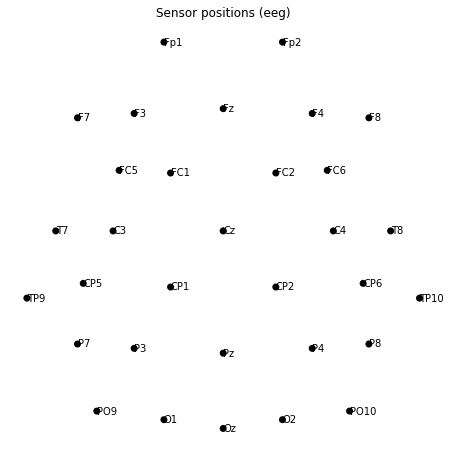

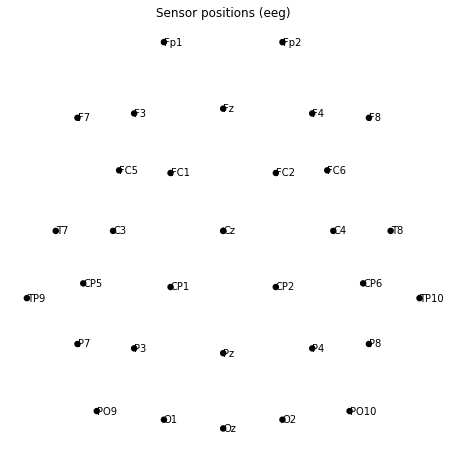

In [37]:
mne.viz.plot_montage(montage)

Creating RawArray with float64 data, n_channels=32, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


<ipython-input-38-b9409427730c>:1: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  montage.plot()


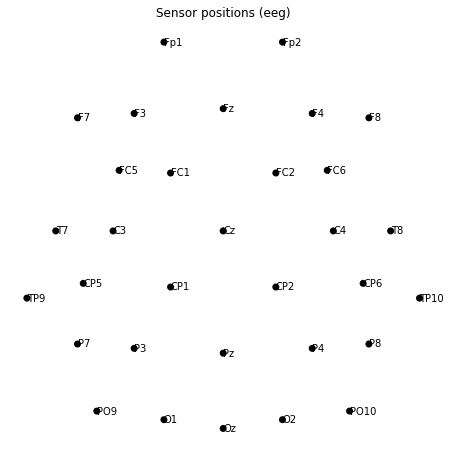

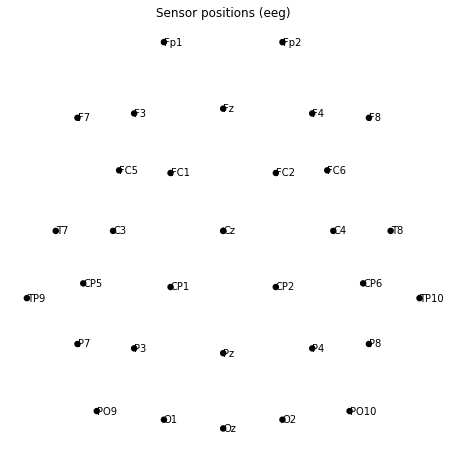

In [38]:
montage.plot()

In [53]:
ch_names

['Fp1',
 'Fp2',
 'F7',
 'F3',
 'Fz',
 'F4',
 'F8',
 'FC5',
 'FC1',
 'FC2',
 'FC6',
 'T7',
 'C3',
 'Cz',
 'C4',
 'T8',
 'TP9',
 'CP5',
 'CP1',
 'CP2',
 'CP6',
 'TP10',
 'P7',
 'P3',
 'Pz',
 'P4',
 'P8',
 'PO9',
 'O1',
 'Oz',
 'O2',
 'PO10']

In [74]:
raw.set_montage(montage)

<ipython-input-74-fe790fd59c77>:1: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


<RawArray | 32 x 800 (1.6 s), ~248 kB, data loaded>

Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.


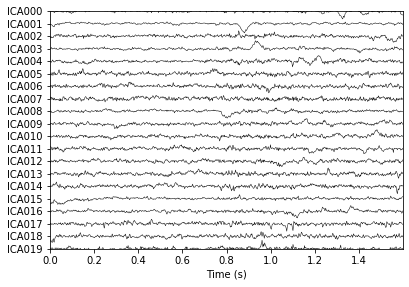

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components
Fitting ICA took 0.2s.


/Users/priyanshi_nigam/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


In [77]:
ica.plot_sources(raw, show_scrollbars=False)
picks_eeg = mne.pick_types(info, meg=False, eeg=True, eog=False, stim=False, exclude='bads')
ica_obj = ica.fit(raw, picks=picks_eeg)
#ica.plot_components(raw, picks = ch_names)

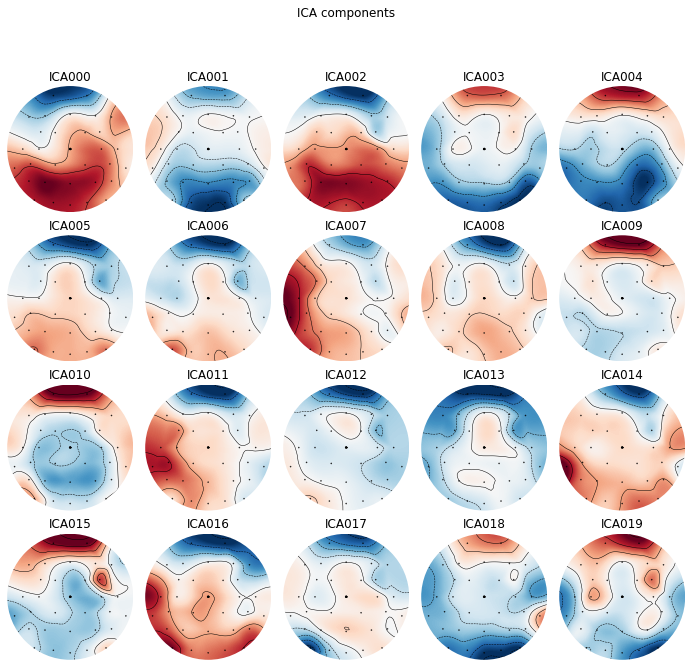

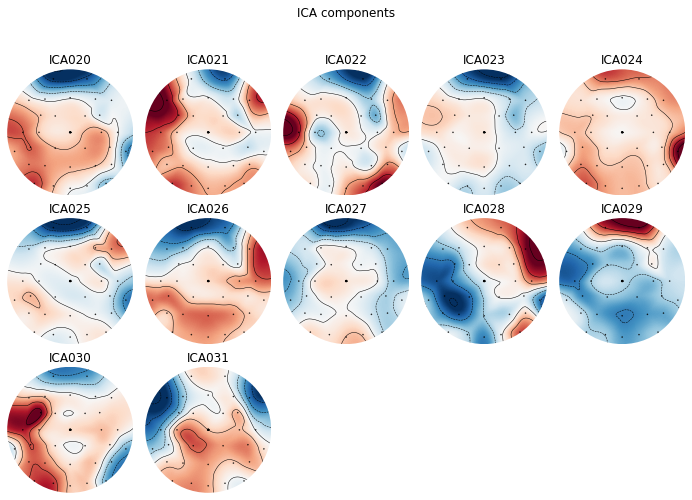

[<Figure size 702x678.24 with 20 Axes>, <Figure size 702x508.68 with 12 Axes>]

In [82]:
mne.viz.plot_ica_components(ica_obj)